In [10]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
csv_path = './data/image_urls.csv'
images_df = pd.read_csv(csv_path)

print("Aperçu du dataset:")
display(images_df.head())

image_dir = './data/images/'
image_files = os.listdir(image_dir)
print(f"Nombre total d'images: {len(image_files)}")

format_files = Counter([ext[-1] for ext in images_df.url.str.split('.')])

print(f"Types de format d'images: {format_files}")

Aperçu du dataset:


,url,id
0,https://c4.staticflickr.com/9/8555/15625756039...,461828
1,https://farm8.staticflickr.com/7214/7337479734...,165352
2,https://farm2.staticflickr.com/3299/3509371657...,224667
3,https://c4.staticflickr.com/1/52/129983132_b66...,602094
4,https://c4.staticflickr.com/1/55/155642663_7e2...,347895


Nombre total d'images: 295
Types de format d'images: Counter({'jpg': 295})


In [14]:
def check_images(image_dir):
    invalid_images = []
    valid_images = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        try:
            with Image.open(img_path) as img:
                valid_images.append(img_file)
                img.verify()
        except (UnidentifiedImageError, IOError) as e:
            invalid_images.append(img_file)
            print(f"Corrupted image found: {os.path.basename(img_file)}")
    
    print(f"valid_images: {len(valid_images)}")
    return invalid_images, valid_images

corrupted_images, valid_image_files = check_images(image_dir)

Corrupted image found: 406453588_b2541371b8_o.jpg
Corrupted image found: 5537502948_503ea812fb_o.jpg
Corrupted image found: 7805590320_6a55e048c2_o.jpg
valid_images: 292


## Analyse des dimensions

Cette section se concentre sur l'analyse des dimensions des images avec pour objectif de visualiser la distribution des largeurs des images pour comprendre leur variabilité.

> La fonction `analyze_image_dimensions` analyse les dimensions des images. Elle calcule les largeurs, hauteurs et rapports d'aspect de chaque image et génère des graphiques pour illustrer la distribution de ces caractéristiques.

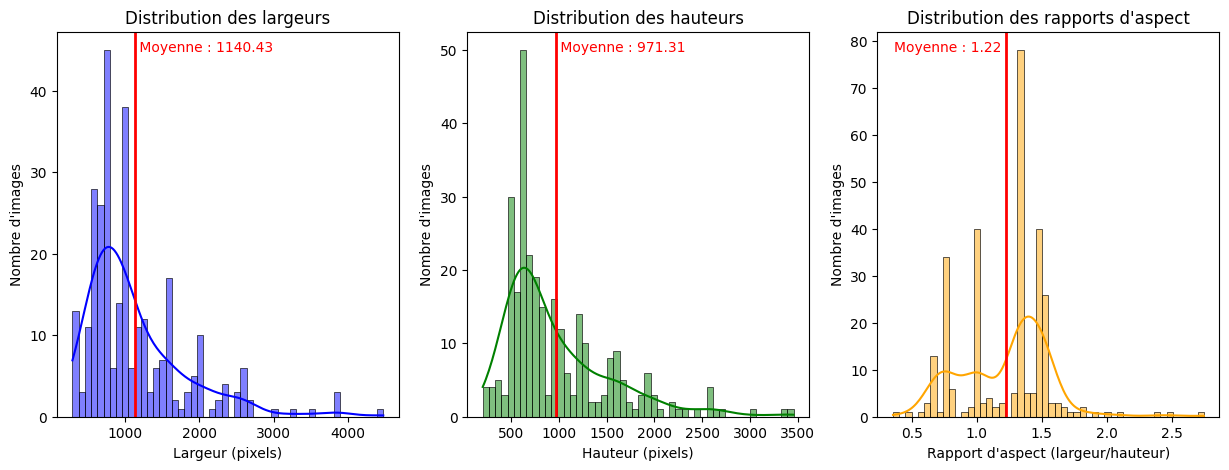

In [7]:
def analyze_image_dimensions(image_dir, images_subset: list = None):
    widths = []
    heights = []
    aspect_ratios = []

    image_names = os.listdir(image_dir) if images_subset is None else images_subset
    for img_name in image_names:
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
            aspect_ratios.append(width / height)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(widths, bins=50, kde=True, color='blue')
    plt.title('Distribution des largeurs')
    plt.xlabel('Largeur (pixels)')
    plt.ylabel('Nombre d\'images')
    mean_widths= sum(widths) / len(widths)
    plt.axvline(mean_widths, color='red', linewidth=2)
    plt.text(x= mean_widths, y=0.95*plt.ylim()[1], fontsize = 10, color="red", s=f" Moyenne : {mean_widths:.2f}")

    plt.subplot(1, 3, 2)
    sns.histplot(heights, bins=50, kde=True, color='green')
    plt.title('Distribution des hauteurs')
    plt.xlabel('Hauteur (pixels)')
    plt.ylabel('Nombre d\'images')
    mean_heights= sum(heights) / len(heights)
    plt.axvline(mean_heights, color='red', linewidth=2)
    plt.text(x= mean_heights, y=0.95*plt.ylim()[1], fontsize = 10, color="red", s=f" Moyenne : {mean_heights:.2f}")

    plt.subplot(1, 3, 3)
    sns.histplot(aspect_ratios, bins=50, kde=True, color='orange')
    plt.title('Distribution des rapports d\'aspect')
    plt.xlabel('Rapport d\'aspect (largeur/hauteur)')
    plt.ylabel('Nombre d\'images')
    mean_ratios = sum(aspect_ratios) / len(aspect_ratios)
    plt.axvline(mean_ratios, color='red', linewidth=2)
    plt.text(x= mean_ratios, y=0.95*plt.ylim()[1], fontsize = 10, color="red", s=f"Moyenne : {mean_ratios:.2f} ", ha="right")

    plt.show()

analyze_image_dimensions(image_dir, images_subset=valid_image_files)


## Analyse des Canaux de Couleur des Images

Cette section examine la répartition des images en couleurs et en niveaux de gris dans un répertoire donné.

> La fonction `analyze_color_channels` identifie le nombre d'images en couleur et en niveaux de gris. Elle distingue les images en fonction du nombre de canaux de couleur (3 pour RGB, 1 pour niveaux de gris).

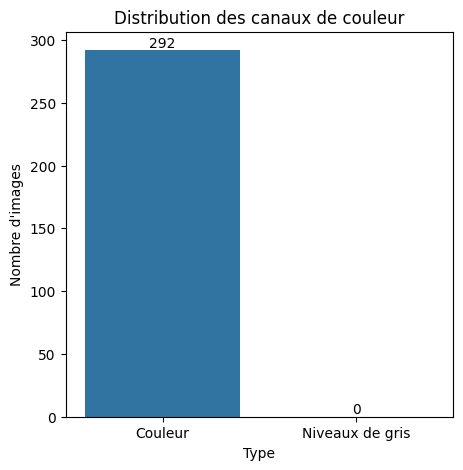

In [8]:
def analyze_color_channels(image_dir, images_subset: list = None):
    color_images = 0
    grayscale_images = 0
    
    image_names = os.listdir(image_dir) if images_subset is None else images_subset
    for img_name in image_names:
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            if len(img.getbands()) == 3:  # RGB
                color_images += 1
            elif len(img.getbands()) == 1:  # Grayscale
                grayscale_images += 1
    
    data = {'Type': ['Couleur', 'Niveaux de gris'],
            'Nombre': [color_images, grayscale_images]}

    plt.figure(figsize=(5, 5))
    ax = sns.barplot(x='Type', y='Nombre', data=pd.DataFrame(data))
    ax.bar_label(ax.containers[0], fontsize=10)
    plt.title('Distribution des canaux de couleur')
    plt.ylabel('Nombre d\'images')
    plt.show()

analyze_color_channels(image_dir, images_subset=valid_image_files)

> La fonction `get_average_color` analyse la coleur moyenne des images pour déterminer s'il existe des déséquilibres importants

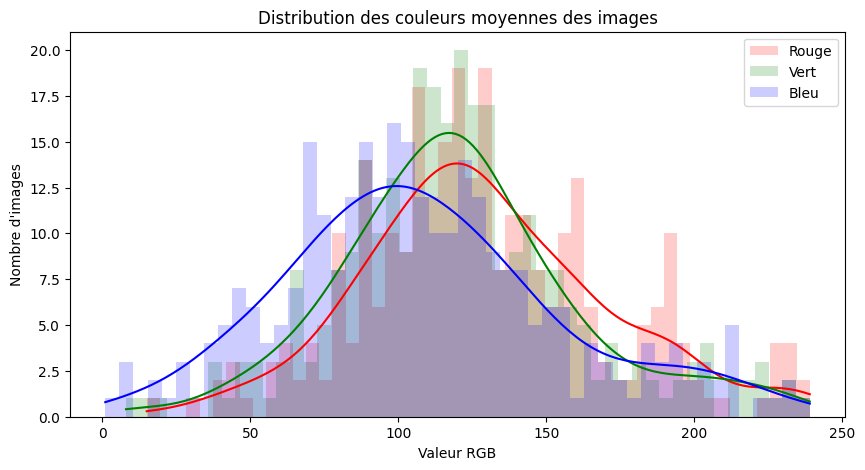

In [9]:
def get_average_color(image_path):
    with Image.open(image_path) as img:
        img = img.resize((50, 50))  # Redimensionner pour accélérer le calcul
        pixels = list(img.getdata())
        avg_color = tuple([sum(channel) // len(channel) for channel in zip(*pixels)])
        return avg_color

average_colors = [get_average_color(os.path.join(image_dir, img)) for img in valid_image_files]

plt.figure(figsize=(10, 5))
sns.histplot([color[0] for color in average_colors], bins=50, kde=True, color='red', label='Rouge', alpha=0.2, edgecolor='none')
sns.histplot([color[1] for color in average_colors], bins=50, kde=True, color='green', label='Vert', alpha=0.2, edgecolor='none')
sns.histplot([color[2] for color in average_colors], bins=50, kde=True, color='blue', label='Bleu', alpha=0.2, edgecolor='none')
plt.title("Distribution des couleurs moyennes des images")
plt.xlabel("Valeur RGB")
plt.ylabel("Nombre d'images")
plt.legend()
plt.show()

### Conclusion des prétraitements envisagés :
1. **Redimensionnement** : Les tailles d'images sont assez variées, nous les redimensionnerons à une taille commune.
2. **Normalisation des pixels** : Nous normaliserons simplement les valeurs de pixels en fonction des statistiques d'ImageNet.
3. **Conversion au format RGB** : Les images semblent déjà en RGB mais peuvent être convertis par sécurité.
4. **Ignorer les images**